In [2]:
import fastai.tabular.all as ft
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [3]:
#!tar xzf latestdata.tar.gz

In [4]:
df = pd.read_csv("latestdata.csv", low_memory=False)#, parse_dates=['date_confirmation'])

In [3]:
df.shape

(2676311, 33)

In [4]:
df.isna().sum()

ID                                0
age                         2098293
sex                         2096154
city                         977681
province                     452664
country                         115
latitude                         61
longitude                        61
geo_resolution                   61
date_onset_symptoms         2414712
date_admission_hospital     2560100
date_confirmation            108489
symptoms                    2674259
lives_in_Wuhan              2671973
travel_history_dates        2673700
travel_history_location     2667089
reported_market_exposure    2675242
additional_information      2630456
chronic_disease_binary            0
chronic_disease             2676096
source                       566964
sequence_available          2676299
outcome                     2368929
date_death_or_discharge     2673163
notes_for_discussion        2675671
location                    2662935
admin3                      2595877
admin2                      

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676311 entries, 0 to 2676310
Data columns (total 33 columns):
ID                          object
age                         object
sex                         object
city                        object
province                    object
country                     object
latitude                    float64
longitude                   float64
geo_resolution              object
date_onset_symptoms         object
date_admission_hospital     object
date_confirmation           object
symptoms                    object
lives_in_Wuhan              object
travel_history_dates        object
travel_history_location     object
reported_market_exposure    object
additional_information      object
chronic_disease_binary      bool
chronic_disease             object
source                      object
sequence_available          object
outcome                     object
date_death_or_discharge     object
notes_for_discussion        object
location    

In [6]:
df.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,...,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,...,NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8029.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,...,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8954.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,...,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,200.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,...,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10091.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,...,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7060.0,NaN,NaN


In [7]:
df['outcome'].head()

0    critical condition, intubated as of 14.02.2020
1                                             death
2                                         discharge
3                                               NaN
4                                               NaN
Name: outcome, dtype: object

## Clean Data

### Select rows where outcome is not NaN

In [8]:
df[df['outcome'].notna()].shape

(307382, 33)

I'm only going to work with non-zero data in Outcome 

In [5]:
df = df[df['outcome'].notna()]

#### Clean outcome data (only death and recovered)

In [12]:
df['outcome'].value_counts()

Hospitalized                                                                202475
Recovered                                                                    93656
Deceased                                                                      5011
recovered                                                                     3659
died                                                                           916
Under treatment                                                                370
Receiving Treatment                                                            257
Alive                                                                          189
discharge                                                                      175
stable                                                                         156
stable condition                                                               133
https://www.mspbs.gov.py/covid-19.php                                          126
disc

In [6]:
df = df.loc[(df['outcome']=='died')| (df['outcome']=='Deceased') |
        (df['outcome']=='Recovered')| (df['outcome']=='recovered')|
      (df['outcome']=='stable')| (df['outcome']=='stable condition')
         ]

In [7]:
df.isna().sum()

ID                               0
age                          98124
sex                          96984
city                         14042
province                       240
country                          0
latitude                         0
longitude                        0
geo_resolution                   0
date_onset_symptoms         100160
date_admission_hospital     103423
date_confirmation               38
symptoms                    103384
lives_in_Wuhan              103478
travel_history_dates        103441
travel_history_location     103248
reported_market_exposure    103529
additional_information       97086
chronic_disease_binary           0
chronic_disease             103420
source                        9186
sequence_available          103530
outcome                          0
date_death_or_discharge     102635
notes_for_discussion        103449
location                    100986
admin3                      103526
admin2                      103211
admin1              

### Remove columns with string

In [8]:
pd.set_option('display.max_columns', None)
df.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
8667,000-1-178,20-29,female,London,Ontario,Canada,42.983611,-81.249722,point,24.01.2020,24.01.2020,31.01.2020,NaN,NaN,23.01.2020,"Wuhan City, Hubei",NaN,recovered,False,NaN,https://news.ontario.ca/mohltc/en/2020/01/ontario-confirms-third-case-of-2019-novel-coronavirus.html (b) https://news.gov.bc.ca/releases/2020HLTH0039-000294,NaN,recovered,19.02.2020,NaN,London,NaN,NaN,Ontario,Canada,5642.0,NaN,NaN
8778,000-1-179,27,male,National Centre for Infectious Diseases,NaN,Singapore,1.322098,103.847200,point,21.01.2020,06.02.2020,06.02.2020,NaN,NaN,NaN,NaN,NaN,"Case 30; He is one of the four Singapore residents who are being investigated at NCID after attending a private business meeting at Grand Hyatt Singapore from 20 to 22 January. The meeting included participants from China, including Hubei, and the confirmed cases from Malaysia and South Korea.",False,NaN,https://www.moh.gov.sg/news-highlights/details/two-more-confirmed-cases-of-novel-coronavirus-infection-in-singapore; https://www.moh.gov.sg/news-highlights/details/three-more-confirmed-cases-of-novel-coronavirus-infection-in-singapore\nhttps://www.channelnewsasia.com/news/singapore/coronavirus-covid-19-singapore-cases-grace-assembly-of-god--12434646,NaN,recovered,14.02.2020,NaN,National Centre for Infectious Diseases,NaN,NaN,NaN,Singapore,6480.0,NaN,NaN
8890,000-1-180,50-59,male,Snohomish County,Washington,United States,48.048180,-121.696000,admin2,NaN,NaN,11.03.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://www.snohd.org/484/Novel-Coronavirus-2019,NaN,recovered,NaN,NaN,NaN,NaN,Snohomish County,Washington,United States,8209.0,NaN,NaN
9556,000-1-186,52,female,Xi'an City,Shaanxi,China,34.107270,108.787200,admin2,23.01.2020,25.01.2020,03.02.2020,NaN,yes,21.01.2020,"Xi'an City, Shaanxi",NaN,NaN,False,NaN,http://sxwjw.shaanxi.gov.cn/art/2020/2/3/art_9_67666.html,NaN,stable,NaN,NaN,NaN,NaN,Xi'an City,Shaanxi,China,9440.0,NaN,NaN
9667,000-1-187,47,female,Xi'an City,Shaanxi,China,34.107270,108.787200,admin2,25.01.2020,28.01.2020,03.02.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,http://sxwjw.shaanxi.gov.cn/art/2020/2/3/art_9_67666.html,NaN,stable,NaN,had dinner with 3 patients diagnosed on January 31,NaN,NaN,Xi'an City,Shaanxi,China,9440.0,NaN,NaN


In [16]:
df.outcome.unique()

array(['recovered', 'stable', 'died', 'Recovered', 'Deceased',
       'stable condition'], dtype=object)

In [9]:
to_delete=['additional_information', #Large text string
           'chronic_disease',
           'notes_for_discussion', #Large text strin
           'source', #Large text string
           'symptoms', #Large text string
          'ID'] #unique values, do not provide info]

In [10]:
df = df.drop(to_delete,axis=1)

### Change date format

In [19]:
df.head()

,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,chronic_disease_binary,sequence_available,outcome,date_death_or_discharge,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
8667,20-29,female,London,Ontario,Canada,42.983611,-81.249722,point,24.01.2020,24.01.2020,31.01.2020,NaN,23.01.2020,"Wuhan City, Hubei",NaN,False,NaN,recovered,19.02.2020,London,NaN,NaN,Ontario,Canada,5642.0,NaN,NaN
8778,27,male,National Centre for Infectious Diseases,NaN,Singapore,1.322098,103.847200,point,21.01.2020,06.02.2020,06.02.2020,NaN,NaN,NaN,NaN,False,NaN,recovered,14.02.2020,National Centre for Infectious Diseases,NaN,NaN,NaN,Singapore,6480.0,NaN,NaN
8890,50-59,male,Snohomish County,Washington,United States,48.048180,-121.696000,admin2,NaN,NaN,11.03.2020,NaN,NaN,NaN,NaN,False,NaN,recovered,NaN,NaN,NaN,Snohomish County,Washington,United States,8209.0,NaN,NaN
9556,52,female,Xi'an City,Shaanxi,China,34.107270,108.787200,admin2,23.01.2020,25.01.2020,03.02.2020,yes,21.01.2020,"Xi'an City, Shaanxi",NaN,False,NaN,stable,NaN,NaN,NaN,Xi'an City,Shaanxi,China,9440.0,NaN,NaN
9667,47,female,Xi'an City,Shaanxi,China,34.107270,108.787200,admin2,25.01.2020,28.01.2020,03.02.2020,NaN,NaN,NaN,NaN,False,NaN,stable,NaN,NaN,NaN,Xi'an City,Shaanxi,China,9440.0,NaN,NaN


#### Delete columns 

In [11]:
to_delete = ['date_death_or_discharge','date_onset_symptoms','travel_history_dates','sequence_available','date_admission_hospital','date_confirmation']


#to_delete = ['sequence_available']

In [12]:
df = df.drop(to_delete,axis=1)

### Set Variables names

In [22]:
df.dtypes

age                          object
sex                          object
city                         object
province                     object
country                      object
latitude                    float64
longitude                   float64
geo_resolution               object
lives_in_Wuhan               object
travel_history_location      object
reported_market_exposure     object
chronic_disease_binary         bool
outcome                      object
location                     object
admin3                       object
admin2                       object
admin1                       object
country_new                  object
admin_id                    float64
data_moderator_initials      object
travel_history_binary        object
dtype: object

In [13]:
df.isna().sum()

age                          98124
sex                          96984
city                         14042
province                       240
country                          0
latitude                         0
longitude                        0
geo_resolution                   0
lives_in_Wuhan              103478
travel_history_location     103248
reported_market_exposure    103529
chronic_disease_binary           0
outcome                          0
location                    100986
admin3                      103526
admin2                      103211
admin1                       91325
country_new                   3464
admin_id                         0
data_moderator_initials       4886
travel_history_binary          144
dtype: int64

In [72]:
df.admin3.unique()

array([nan, 'Tianzhu County', 'Huaxi District', "Yuan'an County"],
      dtype=object)

In [73]:
cat_names = ['age', 'sex', 'city',
             'province', 'country',
            'chronic_disease_binary',
             'country_new', 
            'travel_history_binary']

cont_names = ['latitude', 'longitude'] 

y_names = ['outcome']

In [74]:
#df.columns

### Create Learner

In [75]:
X = ft.range_of(df)

In [76]:
valid_cut = len(df) - 40000

In [77]:
src = ft.TabularPandas(df,
                      procs = [ft.Categorify, ft.FillMissing],
                      cat_names = cat_names,
                      cont_names = cont_names,
                      y_names = y_names, 
                       y_block = ft.CategoryBlock,
                      splits = (X[:valid_cut], X[valid_cut:])
                      )

In [78]:
dls = src.dataloaders(bs=1024)

In [79]:
learn = ft.tabular_learner(dls,
                          #loss_func = ft.accuracy,
                             emb_szs = {'age':8, 'sex':3, 'city':8, 'province':16, 'country':16, 
                                        'latitude':12,'longitude':12, 'chronic_disease_binary':2,
                                         'country_new':10, 'travel_history_binary':2},
                          layers = [64,128,256], #Numero de neuronas en cada capa oculta
                          config = ft.tabular_config(act_cls=nn.LeakyReLU(inplace=True)),
                           #ps(dropout), embedingdropout, sigmoide, batchnorm, activacion
                          opt_func = ft.ranger,
                           metrics = ft.accuracy)

In [80]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(114, 8)
    (1): Embedding(3, 3)
    (2): Embedding(977, 8)
    (3): Embedding(123, 16)
    (4): Embedding(27, 16)
    (5): Embedding(3, 2)
    (6): Embedding(25, 10)
    (7): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=67, out_features=64, bias=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=64, out_features=128, bias=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): LinBnDrop(
      (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.007585775572806597)

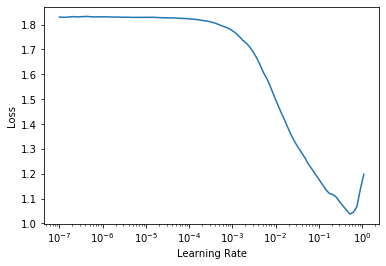

In [81]:
learn.lr_find()

In [71]:
learn.fit_one_cycle(20, 1e-3, div=2, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,1.327592,1.521975,0.896725,00:01
1,0.594943,0.381167,0.919525,00:01
2,0.289575,0.330552,0.919425,00:01
3,0.192249,0.317191,0.914625,00:01
4,0.160771,0.326036,0.912000,00:01
5,0.149579,0.292959,0.919100,00:01
6,0.145378,0.303694,0.923500,00:01
7,0.143606,0.308818,0.920400,00:01
8,0.142366,0.304460,0.918500,00:01
9,0.142947,0.316028,0.915000,00:01
